# Towards SAT Solving for Graph Aggregation
This notebook is based on the notebook for the course on *Computational Social Choice*, demonstrating how to use SAT-solving technology to reason about voting rules, prepared by [Ulle Endriss](https://staff.science.uva.nl/u.endriss/), ILLC, University of Amsterdam (November 2023).

This notebook is part of the implementation of a project extending SAT solving to the graph aggregation domain, as set up by [Endriss & Grandi, 2018](https://dl.acm.org/doi/abs/10.1145/3184558.3186231).

## System Requirements
You need to be able to run [Jupyter Notebooks](https://realpython.com/jupyter-notebook-introduction/) for Python 3 and you need to have the [PySAT](https://pysathq.github.io/) toolkit [installed](https://pysathq.github.io/installation/) on your machine. 

## Imports

In [1]:
from math import factorial
from itertools import permutations
from random import shuffle

In [2]:
from pysat.solvers import Glucose3
from pysat.formula import WCNF
from pysat.examples.musx import MUSX

In [3]:
def solve(cnf):
    solver = Glucose3()
    for clause in cnf: solver.add_clause(clause)
    if solver.solve():
        return solver.get_model()
    else:
        return('UNSATISFIABLE')

The method `enumModels()` can be used to enumerate all satisfying models of a given formula in CNF. Keep in mind that this is a demanding operation and that the number of models can be huge. Note that the object returned by `enumModels()` is an iterator (not a list). A simple way of inspecting it is to use the `list()` method on the object returned by `enumModels()`.

In [4]:
def enumModels(cnf):
    solver = Glucose3()
    for clause in cnf: solver.add_clause(clause)
    return solver.enum_models()

The method `getMUS()` can be used to compute an MUS for a given formula in CNF (which should be unsatisfiable). Note that a given formula might have more than one MUS, and `getMUS()` does not necessarily return the smallest MUS (because computing a cardinality-minimal MUS is a much more demanding operation).

In [5]:
def getMUS(cnf):
    wcnf = WCNF()
    for clause in cnf: wcnf.append(clause, 1)
    mus = MUSX(wcnf,verbosity=0).compute()
    return list(cnf[i-1] for i in mus)

In [6]:
# config, utils, axioms, properties, literals
from config import config
from utils import *
from axioms import *
from properties import *

In [7]:
prop_fns = [cnfIrreflexivity, cnfCompleteness, cnfTransitivity]
graphs = generate_graph_subsets(prop_fns)
# graphs = graphs[:6]
# graphs = generate_graph_subsets([cnfIrreflexivity, cnfConnectedness, cnfTransitivity, cnfCompleteness])
config.update_graphs(graphs)

Updating config.graphs
Updating config.g := 6


[(0, 1), (0, 2), (1, 2)]


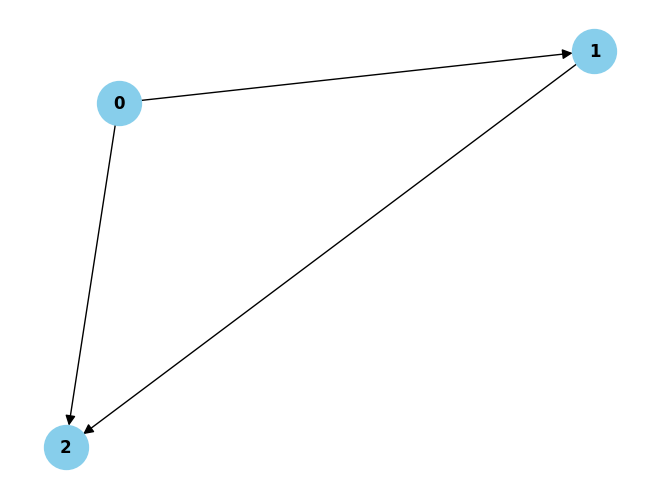

[(0, 2), (1, 0), (1, 2)]


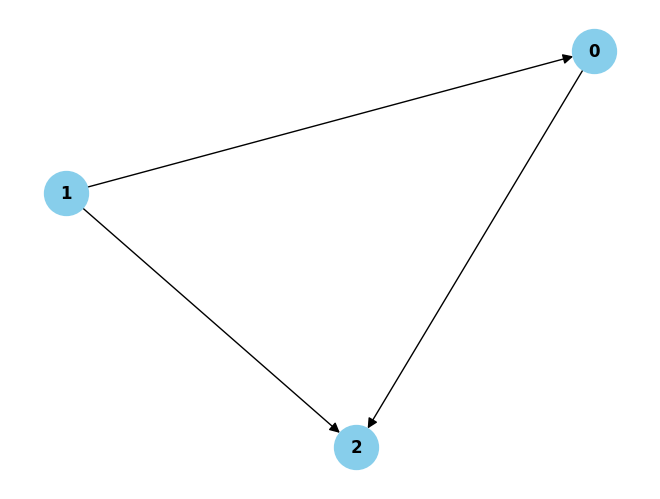

[(1, 0), (1, 2), (2, 0)]


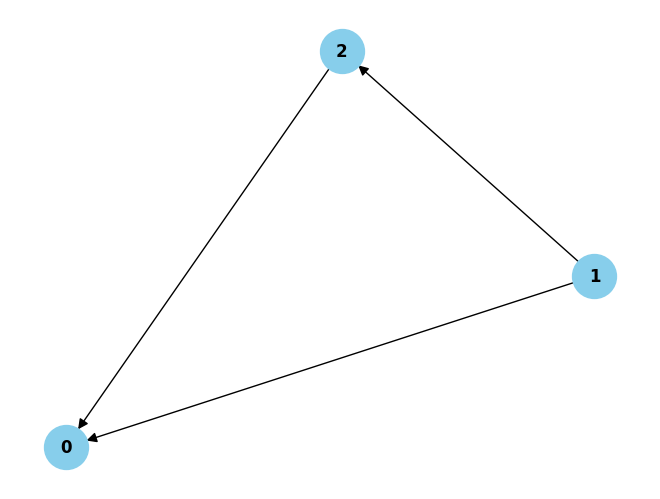

[(0, 1), (0, 2), (2, 1)]


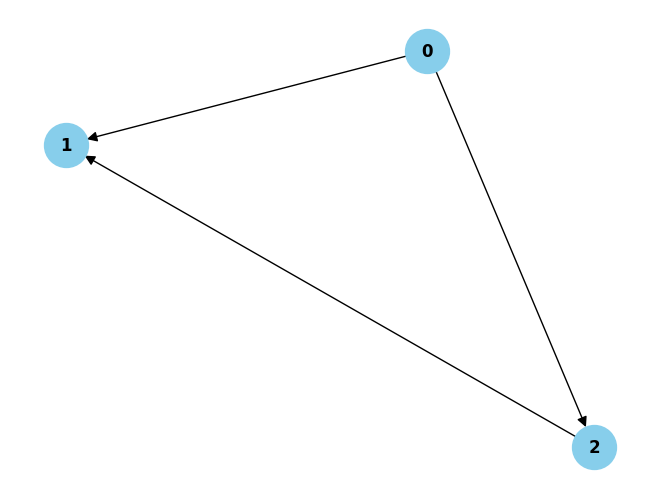

[(0, 1), (2, 0), (2, 1)]


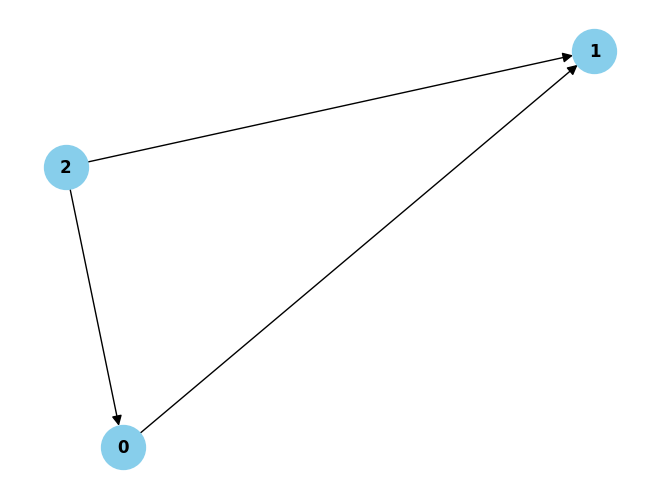

[(1, 0), (2, 0), (2, 1)]


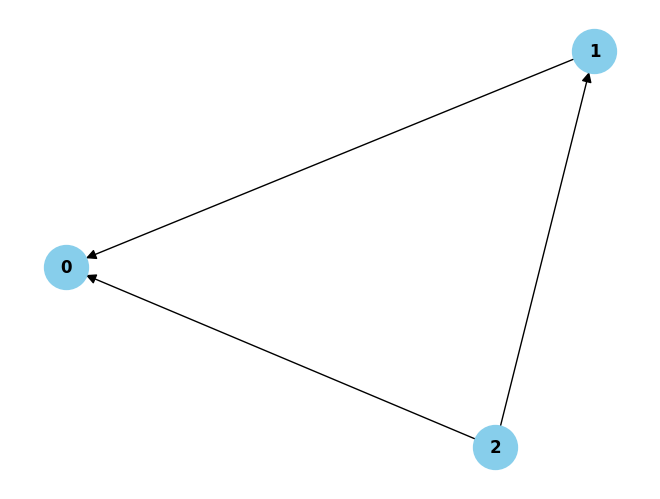

In [8]:
from plot import draw_labeled_graph
for graph in config.graphs:
    edges = get_graph(graph, config.v)
    print(edges)
    draw_labeled_graph(edges, config.v)


In [9]:
from explain import Explain

In [10]:
cr = cr_fn(prop_fns)
# arrow_axioms = [iie, nondictatorship, unanimity, grounded, cr]
arrow_axioms = [iie, nondictatorship, grounded, cr]
iie_cnf = iie()
print("IIE generated")
nondict_cnf = nondictatorship()
print("ND generated")
unanim_cnf = unanimity()
print("UNAN generated")
ground_cnf = grounded()
print("GR generated")
cr_cnf = cr()
print("CR generated")

ex = Explain(arrow_axioms, prop_fns=prop_fns)


IIE generated
ND generated
UNAN generated
GR generated
CR generated


In [11]:
ex = Explain(arrow_axioms, prop_fns=prop_fns)

cnf = iie_cnf + nondict_cnf + unanim_cnf + ground_cnf + cr_cnf
# print(solve(cnf))
print("Total clauses:", len(cnf))
full_sol = list(enumModels(cnf))
print("EXISTING MODELS:", len(full_sol))

if len(full_sol) == 0:
    mus = getMUS(cnf)
    print(ex(mus))

Total clauses: 236199
EXISTING MODELS: 0
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)]
-> (0,1) or 
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
194: [(0, 1), (2, 0), (2, 1)]
-> (0,1)
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)]
-> (1,2) or 
38: [(0, 1), (0, 2), (1, 2)],
44: [(0, 2), (1, 0), (1, 2)],
104: [(1, 0), (1, 2), (2, 0)]
-> (1,2)
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)]
-> (0,2) or 
44: [(0, 2), (1, 0), (1, 2)],
44: [(0, 2), (1, 0), (1, 2)],
134: [(0, 1), (0, 2), (2, 1)]
-> (0,2)
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
194: [(0, 1), (2, 0), (2, 1)]
-> (0,2) or 
44: [(0, 2), (1, 0), (1, 2)],
134: [(0, 1), (0, 2), (2, 1)],
200: [(1, 0), (2, 0), (2, 1)]
-> (0,2)
Independent: not
38: [(0, 1), (0, 2), (1, 2)],
38: [(0, 1), (0, 2), (1, 2)],
194: [(0

In [12]:
# ex = Explain(arrow_axioms, prop_fns=prop_fns)
# del ex.axioms["Independent"]

# # SANS IIE
# cnf = nondict_cnf + unanim_cnf + ground_cnf + cr_cnf
# print("Total clauses:", len(cnf))
# sans_iie = [solve(cnf)]
# print("EXISTING MODELS: AT LEAST", len(sans_iie))

In [13]:
# ex = Explain(arrow_axioms, prop_fns=prop_fns)
# del ex.axioms["Nondictatorial"]

# # SANS NONDICT
# cnf = iie_cnf + unanim_cnf + ground_cnf + cr_cnf
# print("Total clauses:", len(cnf))
# sans_nondict = list(enumModels(cnf))
# print("EXISTING MODELS:", len(sans_nondict))

# if len(sans_nondict) == 0:
#     mus = getMUS(cnf)
#     print(ex(mus))
#     print(len(mus))

In [14]:
# ex = Explain(arrow_axioms, prop_fns=prop_fns)
# del ex.axioms["Unanimous"]

# # SANS UNANIMITY
# cnf = iie_cnf + nondict_cnf + ground_cnf + cr_cnf
# print("Total clauses:", len(cnf))
# sans_unanimity = list(enumModels(cnf))
# print("EXISTING MODELS:", len(sans_unanimity))

# if len(list(sans_unanimity)) == 0:
#     mus = (getMUS(cnf))
#     print(ex(mus))

In [15]:
# ex = Explain(arrow_axioms, prop_fns=prop_fns)
# del ex.axioms["Grounded"]

# # SANS GROUNDED
# cnf = iie_cnf + nondict_cnf + unanim_cnf + cr_cnf
# print("Total clauses:", len(cnf))
# sans_grounded = list(enumModels(cnf))
# print("EXISTING MODELS:", len(sans_grounded))

# if len(list(sans_grounded)) == 0:
#     mus = getMUS(cnf)
#     print(mus)
#     print(ex(mus))

In [16]:
# ex = Explain(arrow_axioms)

# # SANS COLLECTIVE RATIONALITY
# cnf = iie_cnf + nondict_cnf + unanim_cnf + ground_cnf
# print("Total clauses:", len(cnf))
# sans_cr = list(enumModels(cnf))
# print("EXISTING MODELS:", len(sans_cr))


# print(len(sans_cr))
# if len(sans_cr) == 0:
#     mus = getMUS(cnf)
#     print(mus)
#     print(ex(mus))

In [17]:
names = ["IIE", "NONDICT", "UNAN", "GROUND", "CR"]
cnfs = [iie_cnf, nondict_cnf, unanim_cnf, ground_cnf, cr_cnf]
# print([len(opt) for opt in cnfs])

from itertools import combinations

options = [0,1,2,3,4]
for comb_len in range(1,len(options)+1):
    combs = combinations(options, comb_len)
    for comb in combs:
        full_cnf = []
        for item in comb:
            full_cnf += cnfs[item]
        
        if solve(full_cnf) == "UNSATISFIABLE":
            print("UNSATISFIABLE: \t", end="")
        else:
            print("SATISFIABLE: \t", end="")
        
        print(" + ".join([names[item] for item in comb]))
            

SATISFIABLE: 	IIE
SATISFIABLE: 	NONDICT
SATISFIABLE: 	UNAN
SATISFIABLE: 	GROUND
SATISFIABLE: 	CR
SATISFIABLE: 	IIE + NONDICT
SATISFIABLE: 	IIE + UNAN
SATISFIABLE: 	IIE + GROUND
SATISFIABLE: 	IIE + CR
SATISFIABLE: 	NONDICT + UNAN
SATISFIABLE: 	NONDICT + GROUND
SATISFIABLE: 	NONDICT + CR
SATISFIABLE: 	UNAN + GROUND
SATISFIABLE: 	UNAN + CR
SATISFIABLE: 	GROUND + CR
SATISFIABLE: 	IIE + NONDICT + UNAN
SATISFIABLE: 	IIE + NONDICT + GROUND
SATISFIABLE: 	IIE + NONDICT + CR
SATISFIABLE: 	IIE + UNAN + GROUND
UNSATISFIABLE: 	IIE + UNAN + CR
UNSATISFIABLE: 	IIE + GROUND + CR
SATISFIABLE: 	NONDICT + UNAN + GROUND
SATISFIABLE: 	NONDICT + UNAN + CR
SATISFIABLE: 	NONDICT + GROUND + CR
SATISFIABLE: 	UNAN + GROUND + CR
SATISFIABLE: 	IIE + NONDICT + UNAN + GROUND
UNSATISFIABLE: 	IIE + NONDICT + UNAN + CR
UNSATISFIABLE: 	IIE + NONDICT + GROUND + CR
UNSATISFIABLE: 	IIE + UNAN + GROUND + CR
SATISFIABLE: 	NONDICT + UNAN + GROUND + CR
UNSATISFIABLE: 	IIE + NONDICT + UNAN + GROUND + CR


In [18]:
real_graph = []
for E in allProfiles():
    for x in allVertices():
        for y in allVertices():
            real_graph.append((posLiteral(E,x,y), negLiteral(E,x,y)))

In [19]:
len(iie_cnf)
config.v
raise

RuntimeError: No active exception to reraise

In [ ]:
# cnf = iie_cnf + nondict_cnf + unanim_cnf + ground_cnf
cnf = iie_cnf + nondict_cnf + unanim_cnf
solutions = list(enumModels(cnf))
len(solutions)

In [ ]:
cr_rules = []
all_solution_graphs = []
configgraphsexplicit = [set(get_graph(g, config.v)) for g in config.graphs]
print(configgraphsexplicit)
for s, solution in enumerate(solutions):
    is_cr = True
    profile_solutions = {}
    for E in allProfiles():
        profile_solutions[E] = list()

    for literal in solution:
        E,x,y = decodeLiteral(abs(literal), LITDIM)
        if literal > 0:
            profile_solutions[E].append((x,y))

    for winning_graph in profile_solutions.values():
        if set(winning_graph) not in configgraphsexplicit:
#             print(f"Aggregation rule {s} not CR!")
#             print(set(winning_graph))
            is_cr = False
            break
    if is_cr:
#         print(f"Aggregation rule {s} is CR!")
#         print(set(winning_graph))
        cr_rules.append(s)

if len(cr_rules) == 0:
    print("IMPOSSIBILITY")
else:
    print("CR Rules: ", len(cr_rules))

In [ ]:
print("\a")

In [ ]:
ex = Explain(arrow_axioms, prop_fns=[cnfIrreflexivity, cnfCompleteness])
del ex.axioms["Nondictatorial"]
del ex.axioms["Grounded"]
# del ex.axioms["Transitive"]

# SANS NONDICT
cnf = iie_cnf + unanim_cnf + cr_cnf
print("Total clauses:", len(cnf))
sans_nondict = list(enumModels(cnf))
print("EXISTING MODELS:", len(sans_nondict))

if len(sans_nondict) == 0:
    mus = getMUS(cnf)
    print(ex(mus))